CIS 5220 Final Project

# Data Input

In [ ]:
import pandas as pd
import numpy as np
import torch
%matplotlib inline
import matplotlib.pyplot as plt
import math,random,re
import time
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from keras.layers import Embedding, SpatialDropout1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input, Lambda, Layer, Reshape, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from keras.layers import concatenate
from keras.layers.core import Flatten
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CIS522_Final_Project/data_cleaned.csv')
data['splitted_go_labels'] = data['splitted_go_labels'].apply(eval)
data['interactors'] = data['interactors'].apply(eval)

There are total 66841 unique protein sequence, and 24266 labels

In [ ]:
data.head()

,entry,splitted_go_labels,go_labels,sequence,stringid,organismid,interactors
0,A0A024RBG1,"[GO:0005634, GO:0005737, GO:0005829]",GO:0000298; GO:0003723; GO:0005634; GO:0005737...,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,9606.ENSP00000338352,9606,"[NUDT22, NUDT17, NUDT12, NUDT18, NUDT5]"
1,A0A061FBW2,"[GO:0005634, GO:0005737]",GO:0005634; GO:0005737; GO:0008757; GO:0030795...,MEVMQVLHMNKGNGETSYAKNSTVQSKIISVGKPIIEEAVHEISCN...,3641.EOY14825,3641,"[EOY14651, EOY30281, EOY24082, EOX94195, EOY33..."
2,A0A061FDP1,"[GO:0005634, GO:0005737]",GO:0005634; GO:0005737; GO:0008757; GO:0030795...,MEVMQVLHMNRGNGENSYAKNSTVQSKIISIGKPIIEEAVHEISCN...,3641.EOY14822,3641,"[EOY14651, EOY30281, EOY24082, EOX94195, EOY33..."
3,A0A075B734,[GO:0005886],GO:0005886; GO:0006833; GO:0015204; GO:0015250...,MVQASGHRRSTRGSKMVSWSVIAKIQEIWCEEDERKMVREFLAEFM...,9606.ENSP00000456868,9606,"[AQP8, ENSP00000421315, AQP12A, AQP12B, DIP2C]"
4,A0A075B759,"[GO:0005737, GO:0043231]",GO:0000413; GO:0003755; GO:0005737; GO:0006457...,MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,9606.ENSP00000463419,9606,"[NBPF12, RAB28, ACAD10, RPS3A, AIFM1]"


In [ ]:
data.shape

(92135, 7)

# Data processing

First, drop the lower case base in the sequence since we only want to find the sequences that align

In [ ]:
for index, row in dataset.iterrows():
     dataset.at[index, 'seq'] = ''.join(c for c in row['seq'] if c.isupper())

Second, translate the sequence into a one hot encoding 

In [ ]:
ORDER_KEY="ACDEFGHIKLMNPQRSTVYWXBU"
ORDER_LIST=list(ORDER_KEY)

In [ ]:
dataset

,id,go_label,go_class,seq
0,P0DJZ0,GO:0030430,C,MQNNTTGMDTKSLKNCGQPKAVCTHCKHSPPCPQPGCVTKRPPVPP...
1,P32234,GO:0005525,F,MSTILEKISAIESEMARTQKNKATSAHLGLLKAKLAKLRRELISPK...
2,P83011,GO:0043231,C,MIFTAXDRSAIEXV
3,P83010,GO:0043231,C,AGEPANNEDRFNY
4,P81928,GO:0007275,P,MNFLWKGRRFLIAGILPTFEGAADEIVDKENKTYKAFLASKPPEET...
...,...,...,...,...
9995,Q61824,GO:0007173,P,MAERPARRAPPARALLLALAGALLAPRAARGMSLWDQRGTYEVARA...
9996,Q13444,GO:0009986,C,MRLALLWALGLLGAGSPLPSWPLPNIGGTEEQQAESEKAPREPLEP...
9997,Q13444,GO:0070062,C,MRLALLWALGLLGAGSPLPSWPLPNIGGTEEQQAESEKAPREPLEP...
9998,Q13444,GO:0005886,C,MRLALLWALGLLGAGSPLPSWPLPNIGGTEEQQAESEKAPREPLEP...


In [ ]:
oh_encoder = LabelEncoder().fit(ORDER_LIST)

encoded_sequences = np.array([oh_encoder.transform(list(seq)) for seq in dataset.seq])


<ipython-input-9-8d17ba424bc7>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded_sequences = np.array([oh_encoder.transform(list(seq)) for seq in dataset.seq])


Third, pad the sequence due to the varying lengths of the sequences

In [ ]:
max_length = [len(seq) for seq in encoded_sequences]
max_length = max_length[np.argmax(np.array(max_length))]
   
padded_sequences = sequence.pad_sequences(encoded_sequences, maxlen=max_length, padding="post", truncating="post")


Next, encode the functions

In [ ]:
# Encode the functions as one-hot vectors
function_encoder = LabelEncoder().fit(dataset.go_class)
encoded_functions = function_encoder.transform(dataset.go_class)
num_functions = len(function_encoder.classes_)
encoded_functions = np.eye(num_functions)[encoded_functions]

#Baseline models

### 1. CNN

***Advantage***
1. The protein sequence is one-dimensional data with spatial dependencies between adjacent residues, CNNs can capture local patterns such as motifs, domains, and structural features that could be utilized to determine protein function.

2. CNNs detect functionally relevant patterns at different positions within the sequence, and these patterns have same functional significance.

3. CNNs reduces the number of parameters to be learned compared to fully connected networks, which saves time for large protein sequences

***Disadvantage***

CNNs can not capture dependencies or interactions between residues. Input sequences does not have a spatial structure.

Epoch 1/20
125/125 [==============================] - 7s 43ms/step - loss: 1.0220 - accuracy: 0.5019 - val_loss: 1.0846 - val_accuracy: 0.4380
Epoch 2/20
125/125 [==============================] - 5s 43ms/step - loss: 1.0137 - accuracy: 0.5041 - val_loss: 1.0709 - val_accuracy: 0.4380
Epoch 3/20
125/125 [==============================] - 5s 43ms/step - loss: 1.0131 - accuracy: 0.5041 - val_loss: 1.0716 - val_accuracy: 0.4380
Epoch 4/20
125/125 [==============================] - 5s 41ms/step - loss: 1.0123 - accuracy: 0.5041 - val_loss: 1.0696 - val_accuracy: 0.4380
Epoch 5/20
125/125 [==============================] - 5s 41ms/step - loss: 1.0066 - accuracy: 0.5042 - val_loss: 1.0816 - val_accuracy: 0.4380
Epoch 6/20
125/125 [==============================] - 5s 42ms/step - loss: 1.0016 - accuracy: 0.5041 - val_loss: 1.0767 - val_accuracy: 0.4380
Epoch 7/20
125/125 [==============================] - 5s 40ms/step - loss: 0.9958 - accuracy: 0.5004 - val_loss: 1.0731 - val_accuracy: 0.4380

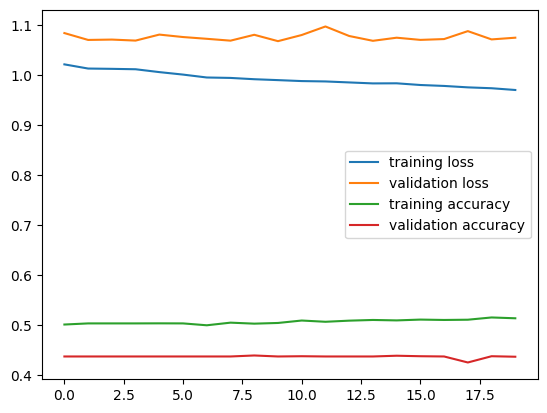

In [ ]:
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(max_length, 1)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(256, 3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_functions, activation='softmax')
])

# Compile the model with appropriate loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the padded sequences and functions and store the training history
history = model.fit(padded_sequences.reshape(padded_sequences.shape[0], padded_sequences.shape[1], 1), 
                    encoded_functions, epochs=20, batch_size=64, validation_split=0.2)

# Plot the loss curve and training accuracy curve
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()



In [ ]:
# Predict the functions of new protein sequences
test_sequences = df.seq[10000:12000]

encoded_new_sequences = np.array([oh_encoder.transform(list(seq)) for seq in test_sequences ])
padded_new_sequences = sequence.pad_sequences(encoded_new_sequences, maxlen=max_length, padding="post", truncating="post")
predicted_functions = model.predict(padded_new_sequences.reshape(padded_new_sequences.shape[0], padded_new_sequences.shape[1], 1))

# Print the predicted functions
predicted_function_labels = function_encoder.inverse_transform(np.argmax(predicted_functions, axis=1))

# compute accuracy
accuracy = np.sum(df.go_class[10000:12000] == predicted_function_labels)/ len(test_sequences)
print('the accuracy is', accuracy)

 6/63 [=>............................] - ETA: 0s

<ipython-input-232-e4f3e24cd2cc>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded_new_sequences = np.array([oh_encoder.transform(list(seq)) for seq in test_sequences ])


63/63 [==============================] - 1s 9ms/step
the accuracy is 0.5665


### 2. AutoEncoder

Autoencoders can be trained on large datasets of labeled proteins to learn protein sequences or structures that capture important functional information.

***Advantage*** 

1. Autoencoders can learn nonlinear representations of the data and capture complex patterns or relationships

2. Autoencoders can handle missing data in protein datasets. 

Preprocess the sequence into numerical format

Source code in keras: https://keras.io/examples/generative/vae/

In this part, we set the maximum length of sequence to 500 since autoencoder is computationally expensive.

Implement the model using Keras

In [ ]:
# One-hot encoding of sequences
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'B', 'U']
aa_dict = {amino_acids[i]: i for i in range(len(amino_acids))}
max_len = 500
n_aa = len(amino_acids)
X = np.zeros((len(dataset), max_len, n_aa))
for i, seq in enumerate(dataset['seq']):
    for j, aa in enumerate(seq[:max_len]):
        X[i, j, aa_dict[aa]] = 1


In [ ]:
# Train/test split
y = dataset.go_class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define autoencoder model
latent_dim = 50
input_shape = (max_len, n_aa)
inputs = Input(shape=input_shape, name='encoder_input')
x = Flatten()(inputs)
encoded = Dense(latent_dim, activation='relu', name='encoded')(x)
x = Dense(max_len*n_aa, activation='sigmoid')(encoded)
decoded = Reshape((max_len, n_aa))(x)

autoencoder = Model(inputs, decoded)

In [ ]:
# Define loss function and compile model
def binary_crossentropy_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)

autoencoder.compile(optimizer='adam', loss=binary_crossentropy_loss)

In [ ]:
epochs = 30
history = autoencoder.fit(X_train, X_train,
                          epochs=epochs,
                          batch_size = 64,
                          shuffle=True,
                          validation_data=(X_test, X_test))

Epoch 1/30
125/125 [==============================] - 10s 21ms/step - loss: 0.1951 - val_loss: 0.1360
Epoch 2/30
125/125 [==============================] - 1s 9ms/step - loss: 0.1316 - val_loss: 0.1221
Epoch 3/30
125/125 [==============================] - 1s 10ms/step - loss: 0.1154 - val_loss: 0.1068
Epoch 4/30
125/125 [==============================] - 1s 8ms/step - loss: 0.1011 - val_loss: 0.0958
Epoch 5/30
125/125 [==============================] - 1s 6ms/step - loss: 0.0901 - val_loss: 0.0864
Epoch 6/30
125/125 [==============================] - 1s 6ms/step - loss: 0.0811 - val_loss: 0.0791
Epoch 7/30
125/125 [==============================] - 1s 8ms/step - loss: 0.0744 - val_loss: 0.0737
Epoch 8/30
125/125 [==============================] - 1s 9ms/step - loss: 0.0696 - val_loss: 0.0699
Epoch 9/30
125/125 [==============================] - 1s 8ms/step - loss: 0.0662 - val_loss: 0.0672
Epoch 10/30
125/125 [==============================] - 2s 16ms/step - loss: 0.0636 - val_loss: 0.

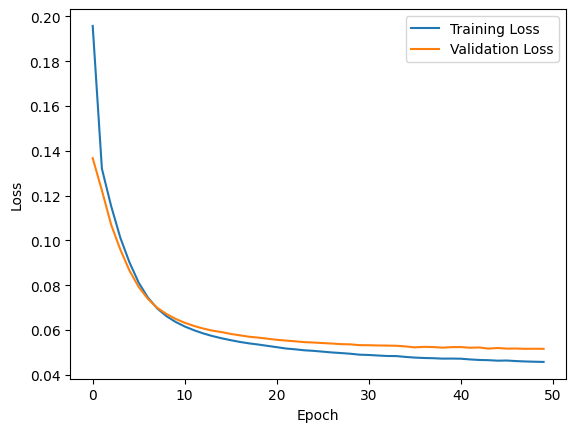

In [ ]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

we can use the encoded sequences as input to a classifier model (e.g. logistic regression or a neural network) to predict protein function:

In [ ]:
# get the encoder and predictions
encoder = Model(inputs, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)


num_classes = len(set(dataset.go_class))
inputs = Input(shape=(50,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

63/63 [==============================] - 0s 2ms/step


In [ ]:
classifier = Model(inputs=inputs, outputs=predictions)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the classifier model
y_train_encoded = np.array(pd.get_dummies(y_train))
y_test_encoded = np.array(pd.get_dummies(y_test))

classifier.fit(X_train_encoded, y_train_encoded, epochs=30, batch_size=32, shuffle=True, validation_data=(X_test_encoded, y_test_encoded))
# Evaluate the model
test_loss, test_acc = classifier.evaluate(X_test_encoded, y_test_encoded)
print('Test accuracy:', test_acc)



Epoch 1/30
250/250 [==============================] - 4s 9ms/step - loss: 1.0098 - accuracy: 0.4945 - val_loss: 1.0454 - val_accuracy: 0.4730
Epoch 2/30
250/250 [==============================] - 1s 6ms/step - loss: 0.9986 - accuracy: 0.4969 - val_loss: 1.0087 - val_accuracy: 0.4695
Epoch 3/30
250/250 [==============================] - 1s 5ms/step - loss: 0.9866 - accuracy: 0.4990 - val_loss: 0.9981 - val_accuracy: 0.4770
Epoch 4/30
250/250 [==============================] - 1s 4ms/step - loss: 0.9748 - accuracy: 0.5073 - val_loss: 1.0090 - val_accuracy: 0.4800
Epoch 5/30
250/250 [==============================] - 1s 4ms/step - loss: 0.9749 - accuracy: 0.5106 - val_loss: 0.9976 - val_accuracy: 0.4835
Epoch 6/30
250/250 [==============================] - 1s 4ms/step - loss: 0.9744 - accuracy: 0.5064 - val_loss: 1.0030 - val_accuracy: 0.4805
Epoch 7/30
250/250 [==============================] - 1s 4ms/step - loss: 0.9701 - accuracy: 0.5034 - val_loss: 1.0011 - val_accuracy: 0.4680
Epoch 

***possible reasons for low accuracy***

1. Insufficient data for training \\
2. Chosen number of features is smaller. CNN has 3700 features, the maximal length of sequences, while we only choose 500 features with autoencoder due to computation limit. 
3. Class imbalance

### 3. RNN (Recurrent Neural Network)

RNNs are useful for this task because they can model the sequential dependencies between amino acids. Though RNNs may not achieve high accuracy. Nonetheless, RNNs is a useful tool for analyzing protein sequences and identifying potential functional domains. 

In the following implementations, we choose ***LSTM***. LSTMs have a unique memory cell that can store information over extended periods of time and selectively forget or remember information as needed. In the case of protein function prediction, the amino acid sequence of a protein is a sequential input, and the information contained in each amino acid can be relevant to the protein's function, even if it is far away in the sequence. Therefore, it is important for the model to be able to retain and selectively use information from any point in the sequence to predict the function.

Reference: https://www.sciencedirect.com/science/article/pii/S0003269720304875#!



In [ ]:
dataset = df[:12000]
# One-hot encoding of sequences
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'B', 'U']
aa_dict = {amino_acids[i]: i for i in range(len(amino_acids))}
max_len = 1000
n_aa = len(amino_acids)
X = np.zeros((len(dataset), max_len, n_aa))
for i, seq in enumerate(dataset['seq']):
    for j, aa in enumerate(seq[:max_len]):
        X[i, j, aa_dict[aa]] = 1
y = np.array(dataset.go_class)
num_classes = len(np.unique(y))

In [ ]:
# split the train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=66)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=66)

In [ ]:
y_train = np.array(pd.get_dummies(y_train))
y_val = np.array(pd.get_dummies(y_val))
y_test = np.array(pd.get_dummies(y_test))

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(None, len(ORDER_KEY)),return_sequences = True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with adam optimizer categorical cross-entropy loss 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training set
history = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
136/136 [==============================] - 19s 95ms/step - loss: 1.0293 - accuracy: 0.5042 - val_loss: 1.0269 - val_accuracy: 0.4980
Epoch 2/30
136/136 [==============================] - 12s 87ms/step - loss: 1.0211 - accuracy: 0.5058 - val_loss: 1.0244 - val_accuracy: 0.4980
Epoch 3/30
136/136 [==============================] - 11s 83ms/step - loss: 1.0195 - accuracy: 0.5058 - val_loss: 1.0245 - val_accuracy: 0.4980
Epoch 4/30
136/136 [==============================] - 11s 84ms/step - loss: 1.0192 - accuracy: 0.5058 - val_loss: 1.0228 - val_accuracy: 0.4980
Epoch 5/30
136/136 [==============================] - 11s 83ms/step - loss: 1.0186 - accuracy: 0.5058 - val_loss: 1.0217 - val_accuracy: 0.4980
Epoch 6/30
136/136 [==============================] - 12s 87ms/step - loss: 1.0188 - accuracy: 0.5054 - val_loss: 1.0226 - val_accuracy: 0.5000
Epoch 7/30
136/136 [==============================] - 11s 81ms/step - loss: 1.0170 - accuracy: 0.5077 - val_loss: 1.0229 - val_accuracy:

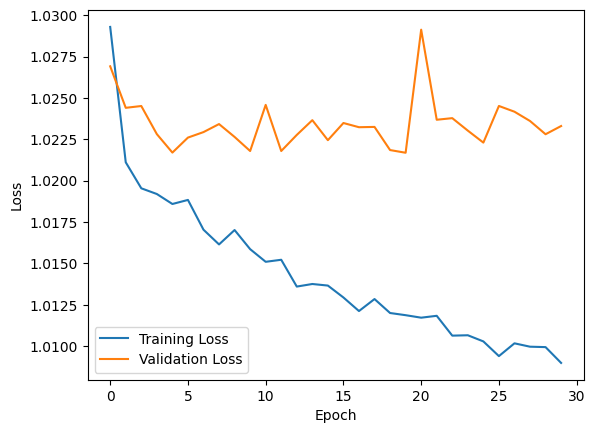

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the test accuracy
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

57/57 [==============================] - 2s 40ms/step - loss: 1.0184 - accuracy: 0.4956
Test loss: 1.018, Test accuracy: 0.496


### 4. GCN (Graph Convolutional Networks)

Graph Convolutional Networks (GCNs are a type of geometric deep learning model that can operate on graph-structured data, such as protein sequences and functions.

GCNs can be used to learn amino acids in protein sequences By leveraging the graph structure, GCNs can capture local and global contextual information, which can be useful for predicting protein sequences based on sequences and functions.

GCN also allos for the incorporation of prior domain knowledge, such as protein structure information into the graph representation. GCN could also handle variable-length protein sequences.



In [ ]:
functions = dataset['go_class'].values
sequences = dataset['seq'].values

# Convert protein functions to numerical labels
function_labels = dataset['go_class'].astype('category').cat.codes.values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, function_labels, test_size=0.2, random_state=42)

Tokenizer provides a convenient way to preprocess and tokenize protein sequences into a format that can be fed into a neural network for training or prediction.

each character in the sequence is treated as a separate token. The resulting numerical sequences are then padded to a fixed length

In [ ]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad protein sequences to a fixed length
max_len = max([len(x) for x in X_train_seq])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)

In [ ]:
y_train = np.array(pd.get_dummies(y_train))
y_test = np.array(pd.get_dummies(y_test))

In [ ]:
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
X_train.shape, y_train.shape

((9600,), (9600, 3))

In [ ]:
protein_sequences = X_train_padded

In [ ]:
input_dim = protein_sequences.shape[1]  # Input dimension based on the length of protein sequences

protein_sequences = np.expand_dims(protein_sequences, axis=2)

# Input layer
input_layer = Input(shape=(input_dim, 1))

# Graph convolutional layers
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# Flatten the output of the graph convolutional layers
flatten = Flatten()(pool2)

# Dense layers with dropout regularization
dense1 = Dense(units=128, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(units=64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Output layer with softmax activation for multi-class classification
output = Dense(units=num_classes, activation='softmax')(dropout2)

# Create the model
model = Model(inputs=input_layer, outputs=output)

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# train the model
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=64)

Epoch 1/50
150/150 [==============================] - 3s 14ms/step - loss: 1.3598 - accuracy: 0.4730
Epoch 2/50
150/150 [==============================] - 2s 13ms/step - loss: 1.0146 - accuracy: 0.5056
Epoch 3/50
150/150 [==============================] - 2s 14ms/step - loss: 1.0042 - accuracy: 0.5101
Epoch 4/50
150/150 [==============================] - 2s 14ms/step - loss: 0.9899 - accuracy: 0.5109
Epoch 5/50
150/150 [==============================] - 2s 15ms/step - loss: 0.9843 - accuracy: 0.5119
Epoch 6/50
150/150 [==============================] - 2s 14ms/step - loss: 0.9738 - accuracy: 0.5186
Epoch 7/50
150/150 [==============================] - 2s 14ms/step - loss: 0.9654 - accuracy: 0.5221
Epoch 8/50
150/150 [==============================] - 2s 14ms/step - loss: 0.9627 - accuracy: 0.5248
Epoch 9/50
150/150 [==============================] - 2s 14ms/step - loss: 0.9586 - accuracy: 0.5213
Epoch 10/50
150/150 [==============================] - 2s 14ms/step - loss: 0.9512 - accura

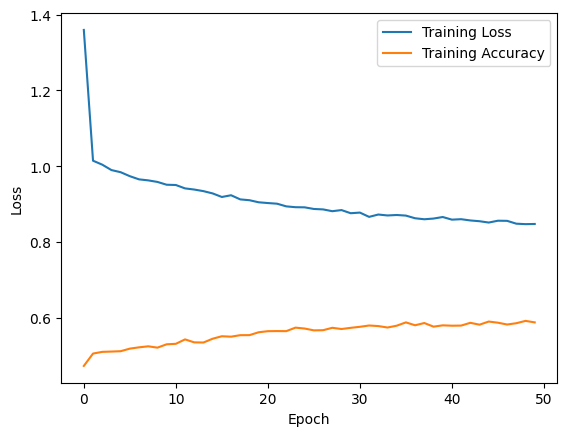

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)

print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

75/75 [==============================] - 1s 5ms/step - loss: 1.1247 - accuracy: 0.4954
Test loss: 1.125, Test accuracy: 0.495


***Discussion on the low test accuracy***

1. The current architecture may not be optimal for the specific protein function prediction task.

2. Class imbalance

3. Limited training data

4. Hyperparameter tuning

***Comparison with CNN***

1. In a GCN, convolutional operations are applied to the nodes and their neighboring nodes in the graph, aggregating information from neighboring nodes to update node representations

2. In a GCN, features are represented as node embeddings or representations, which capture the information from the node itself and its neighborhood in the graph.

### 5. Random Forest

Random Forest could handle non-linear relationship

In [ ]:
X_train_padded.shape

(9600, 3770)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=66)

# Train the classifier
rf.fit(X_train_padded, y_train)

RandomForestClassifier(random_state=66)

In [ ]:
# Make predictions on the test set
y_pred_test = rf.predict(X_test_padded)

# Evaluate the accuracy of the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test accuracy:", accuracy_test)

Test accuracy: 0.3829166666666667
